# Allen atlas image regression

## 1. Opening AllenSDK, Packages and Isocortex map

In [1]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
import ants
import nrrd
import scipy
import cv2
from PIL import Image
import nrrd
from collections import OrderedDict

In [2]:
experiment_name = "RS_M38_22aout"

In [3]:
#directory = search_for_file_path()
rsp, tree = open_AllenSDK() #resolution of annotation can be changed with karg resolution. default = 25 micrometer
isocortex_map, id_name_dict, bregma = map_generator(rsp, tree, structure='Isocortex')

#sma_mask = create_mask(isocortex_map, 656)
contour = create_contour(isocortex_map)

['annotation_25.nrrd']


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2251.70it/s]


## 2. Plotting regions and contours for open_AllenSDK validation

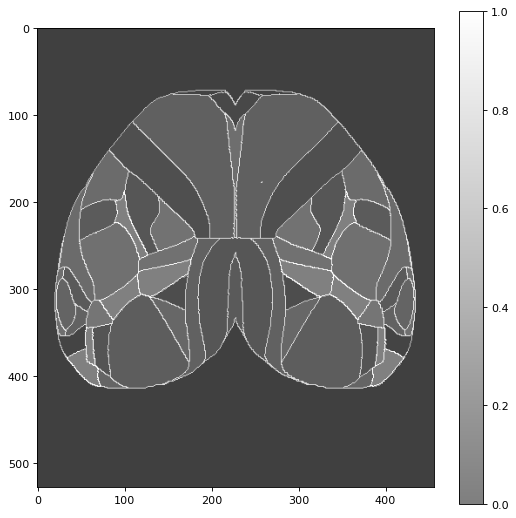

In [4]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
plt.imshow(isocortex_map,vmax=1300, cmap='gray', alpha=0.5)
plt.imshow(contour, cmap='binary_r', alpha=0.5)
plt.colorbar()
plt.show()

## 3. Changing to local directory to save images and automate process

#### (Also creates a new folder named experiment_name if it does not exist yet)

In [5]:
# Changing directory for local_dir (where every registration will be made)
local_dir='/Users/vincentchouinard/Documents/Maitrise/Registration'
os.chdir(local_dir)


newfolderpath = "".join([local_dir,  '/', experiment_name])
newfolderpath = Path(newfolderpath)

if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)
    print('New folder named "{}" was created: Add picture(s) to the folder for the registration process.'.format(newfolderpath))

# Changing directory to newfolderpath
os.chdir(newfolderpath)

## 4. Create isocortex Mask

In [9]:
isocortex_mask = np.zeros(isocortex_map.shape)
mask_list = []
for i in id_name_dict:
    mask_list.append(i)
isocortex_mask = create_mask(isocortex_map, mask_list)

print('List of IDs in the cortex map imported from Allen  :  ', mask_list)

List of IDs in the cortex map imported from Allen  :   [68, 97, 171, 281, 320, 421, 442, 450, 484, 527, 542, 558, 593, 656, 671, 696, 735, 750, 805, 836, 873, 878, 897, 935, 959, 981, 1006, 1030, 1074, 182305693, 312782550, 312782578, 312782604, 312782632]


## 5. Creates surgery_mask, saves both isocortex_mask / surgery_mask / contour in .tif

In [7]:
# Gets the right PATH for surgery_image

surgery_image_path = search_path(path_type='file')
surgery_image_path = Path(surgery_image_path)


# SELECTS A MASK and outputs a binary npy
%matplotlib qt


surgery_image = cv2.imread(str(surgery_image_path))
surgery_mask = select_mask(surgery_image)

You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


In [8]:
# SAVES the mask in .tif

surgery_mask_name = 'surgery_mask'
npy_to_tif(surgery_mask, surgery_mask_name, path=surgery_image_path.parents[0])


# SAVES isocortex_mask in .tif


isocortex_mask_name = 'isocortex_mask'
npy_to_tif(isocortex_mask, isocortex_mask_name, path=surgery_image_path.parents[0])

# SAVES contour in .tif

contour_name = 'contour'
npy_to_tif(contour, contour_name, path=surgery_image_path.parents[0])

## 5.2 Measure resolution factor between isocortex (Allen) and surgery (picture) masks

In [9]:
def widest_row(mask):
    widest = 0
    n = 0
    for i in range(mask.shape[0]):
        nonzero_count = np.count_nonzero(mask[i,:])
        if np.count_nonzero(mask[i,:]) > n:
            widest = i
            n = nonzero_count
    return widest, n

def resolution_factor(norm_mask, comp_mask):
    # gives resolution_factor between two different dimension masks
    _, norm = widest_row(norm_mask)
    _, comp = widest_row(comp_mask)
    return norm/comp

# This will be used to guide the registration for big gaps pixel dimensions
res_fact = resolution_factor(surgery_mask, isocortex_mask)
print(res_fact)

2.572463768115942


## 6. Creates .nrrd files

In [10]:
%matplotlib inline

In [11]:
# Find paths here. Remember that the working directory is already "experiment_name", so only file name is
# necessary. 
search = False

surgeryPath = "/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg"
windowPath = "/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_214623942.jpg"

if search:
    surgeryPath = search_path(path_type="file")
    windowPath = search_path(path_type="file")

#### surgery_image.nrrd

In [12]:
im = cv2.imread(surgeryPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_image.nrrd",im)

#### window_image.nrrd

In [13]:
im2 = cv2.imread(windowPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("window_image.nrrd", im2)

#### isocortex_mask.nrrd

In [14]:
im3 = cv2.imread("isocortex_mask.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("isocortex_mask.nrrd", im3)

#### surgery_mask.nrrd

In [15]:
im4 = cv2.imread("surgery_mask.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_mask.nrrd", im4)

#### contour.nrrd

In [16]:
im5 = cv2.imread("contour.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("contour.nrrd", im5)

## Checkup of nrrd headers

#### Let's hardcode a Header to test multiple space directions

In [49]:
res_fact = 2.57  #for tests

In [50]:
data1, header1 = nrrd.read('surgery_mask.nrrd')

header1 = OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', np.array([1378, 1208])),
             ('space directions',
              np.array([[round(25./res_fact,2), 0. ],
                     [0. , round(25./res_fact,2)]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

nrrd.write('surgery_mask_test.nrrd', data1, header1)

In [51]:
data2, header2 = nrrd.read('isocortex_mask.nrrd')

header2 = OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', np.array([456, 528])),
             ('space directions',
              np.array([[25.,  0. ],
                     [ 0. , 25.]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

nrrd.write('isocortex_mask_test.nrrd', data2, header2)

## 7. Opening masks and finding transform

In [52]:
ants_surgery_mask = ants.image_read("surgery_mask_test.nrrd")
ants_isocortex_mask = ants.image_read("isocortex_mask_test.nrrd")

In [53]:
mytx = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask
                         , type_of_transform = 'SyNRA', syn_sampling = 12)

warped_isocortex_mask = ants.apply_transforms(ants_surgery_mask
                                              , ants_isocortex_mask, mytx['fwdtransforms'])

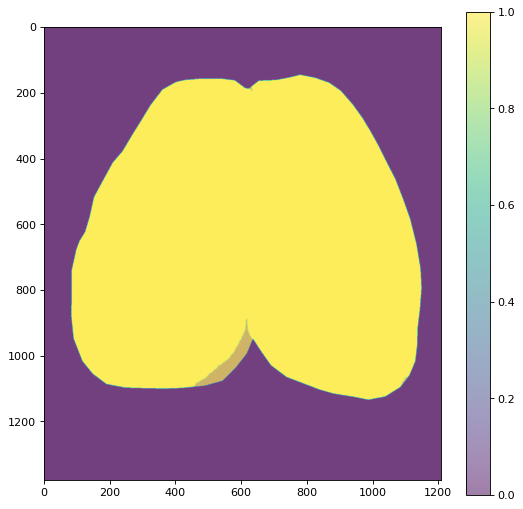

In [54]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(warped_isocortex_mask.numpy(), alpha=0.5)
plt.imshow(ants_surgery_mask.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

## Tests pour warp les contours

In [55]:
ants_contour = ants.from_numpy(contour, spacing=(25.,25.))
ants_surgery_image = ants.image_read("surgery_image.nrrd")
warped_contour = ants.apply_transforms(ants_surgery_mask, ants_contour, mytx['fwdtransforms'])

In [56]:
ants_contour

ANTsImage
	 Pixel Type : unsigned char (uint8)
	 Components : 1
	 Dimensions : (528, 456)
	 Spacing    : (25.0, 25.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

In [57]:
np.unique(warped_contour.numpy())

array([0.0000000e+00, 1.7555431e-06, 4.8922375e-06, ..., 9.9998790e-01,
       9.9999797e-01, 1.0000000e+00], dtype=float32)

In [78]:
warped_contour

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1378, 1208)
	 Spacing    : (9.73, 9.73)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

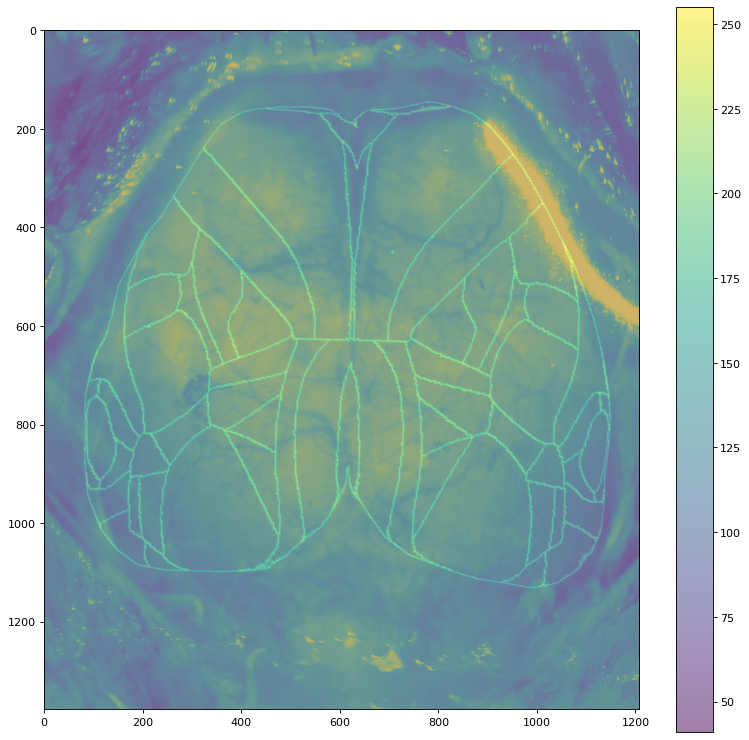

In [58]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=80)

plt.imshow(warped_contour.numpy(), alpha=0.5)
plt.imshow(ants_surgery_image.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

# 2nd part of registration with landmarks

In [10]:
%matplotlib qt
# Gets the right PATHs

surgery_image_path = search_path(path_type='file')
surgery_image_path = Path(surgery_image_path)

window_image_path = search_path(path_type='file')
window_image_path = Path(window_image_path)

surgery_image = cv2.imread(str(surgery_image_path), cv2.IMREAD_GRAYSCALE)
window_image = cv2.imread(str(window_image_path), cv2.IMREAD_GRAYSCALE)

You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg
You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_214623942.jpg


In [11]:
# Autocrops window_image vertically so it works when concatenated with surgery_image

# if surgery_image.shape[0] - window_image.shape[0] < 0:
#     surplus = abs(surgery_image.shape[0] - window_image.shape[0])
#     window_image = window_image[int(np.ceil(surplus/2)):int(-np.floor(surplus/2)),:]
    
# hori = np.concatenate((surgery_image, window_image), axis=1)

# binary_concat = np.zeros((hori.shape[0], hori.shape[1]))

In [12]:
%matplotlib qt

In [13]:
def select_labels(ref_image, adj_image):
    # reference image (ref_image) has a fixed vertical shape, and adjusted image (adj_image)
    # is adjusted vertically to have the same shape before being horizontally concatenated.
    
    # Autocrops window_image vertically so it works when concatenated with surgery_image

    if ref_image.shape[0] - adj_image.shape[0] < 0:
        surplus = abs(ref_image.shape[0] - adj_image.shape[0])
        adj_image = adj_image[int(np.ceil(surplus/2)):int(-np.floor(surplus/2)),:]
        
    if ref_image.shape[0] - adj_image.shape[0] > 0:
        return "Oh fuck, forgot to code for if ref_image is bigger, you might just switch both args"

    hori = np.concatenate((ref_image, adj_image), axis=1)

    print(
        'Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.')
    # Initialize variables
    label_points = []
    label_completed = False

    def mouse_callback(event, x, y, flags, param):
        nonlocal label_points, label_completed

        if event == cv2.EVENT_LBUTTONDOWN:
            label_points.append((x, y))
            cv2.circle(hori, (x, y), 4, (0, 0, 0), -1)
            


    # Create a window to display the image
    cv2.namedWindow('Select Labels')
    cv2.imshow('Select Labels', hori)

    # Register the mouse callback function
    cv2.setMouseCallback('Select Labels', mouse_callback)
    while not label_completed:
        cv2.imshow('Select Labels', hori)
        key = cv2.waitKey(10)

        if key == 27:
            label_completed = True

    # Convert the ROI points to a NumPy array
    label_points = np.array(label_points)
    
    if ref_image.ndim > 2:
        return "Images inputed are in RGB, we need them greyscale. Load them with 'cv2.IMREAD_GRAYSCALE'."

    # Create a binary mask
    
    ref_mask = np.zeros_like(ref_image, dtype=np.uint8)
    adj_mask = np.zeros_like(adj_image, dtype=np.uint8)

    ref_labellist = []
    adj_labellist = []
    
    for label in label_points:
        if ref_image.shape[1] < label[0]:
            adj_mask[label[1],label[0]-ref_image.shape[1]] = 1
            label[0] = label[0] - ref_image.shape[1]
            adj_labellist.append(label)
            
        else:
            ref_mask[label[1],label[0]] = 1
            ref_labellist.append(label)

    adj_labels = np.array(adj_labellist)
    ref_labels = np.array(ref_labellist)

    cv2.destroyWindow('Select Labels')
    cv2.destroyAllWindows()
    
    return ref_mask, adj_mask, ref_labels, adj_labels

In [14]:
reference_mask, adjusted_mask, surgery_labels, window_labels = select_labels(surgery_image, window_image)

Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


In [11]:
from scipy.ndimage import binary_dilation

structuring_element = np.ones((30,30), dtype=np.uint8)

dilated_ref = binary_dilation(reference_mask, structure=structuring_element)

In [12]:
from scipy.ndimage import binary_dilation

structuring_element = np.ones((30,30), dtype=np.uint8)

dilated_adj = binary_dilation(adjusted_mask, structure=structuring_element)

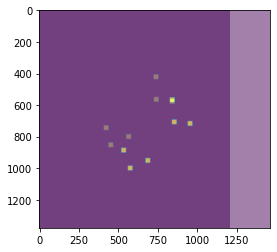

In [84]:
plt.imshow(dilated_ref, alpha=0.5)
plt.imshow(dilated_adj, alpha=0.5)
plt.show()

### (Ici j'ai échangé adjusted avec reference pcq on veut chirurgie vers window et non l'inverse, j'avais gardé le fixed à chirurgie par habitude mais c'est con)

In [85]:
ants_adjusted_mask = ants.from_numpy(dilated_ref.astype(np.uint8))
ants_reference_mask = ants.from_numpy(dilated_adj.astype(np.uint8))

In [86]:
mytx2 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask
                         , type_of_transform = 'Rigid')

warped_window = ants.apply_transforms(ants_reference_mask
                                              , ants_adjusted_mask, mytx2['fwdtransforms'])

print("Done")
mytx3 = ants.registration(fixed=ants_reference_mask, moving=warped_window
                         , type_of_transform = 'Affine')

warped_window2 = ants.apply_transforms(ants_reference_mask
                                              , warped_window, mytx3['fwdtransforms'])

print("Done")
mytx4 = ants.registration(fixed=ants_reference_mask, moving=warped_window2
                         , type_of_transform = 'SyN')

warped_window3 = ants.apply_transforms(ants_reference_mask
                                              , warped_window2, mytx4['fwdtransforms'])
print("Done")

Done
Done
Done


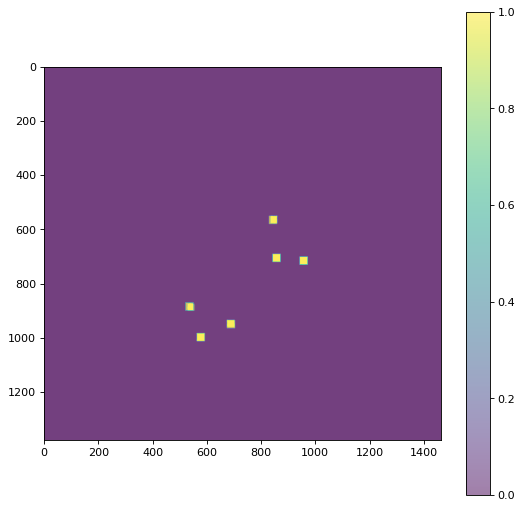

In [96]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(warped_window3.numpy(), alpha=0.5)
plt.imshow(ants_reference_mask.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

In [91]:
ants_window_image = ants.image_read("window_image.nrrd")

In [97]:
warped_contour.set_spacing(((1.,1.)))

In [99]:
warped_rigid = ants.apply_transforms(ants_window_image
                                              , warped_contour, mytx2['fwdtransforms'])
warped_affine = ants.apply_transforms(ants_window_image
                                              , warped_rigid, mytx3['fwdtransforms'])
double_transformed_contour = ants.apply_transforms(ants_window_image
                                              , warped_affine, mytx4['fwdtransforms'])

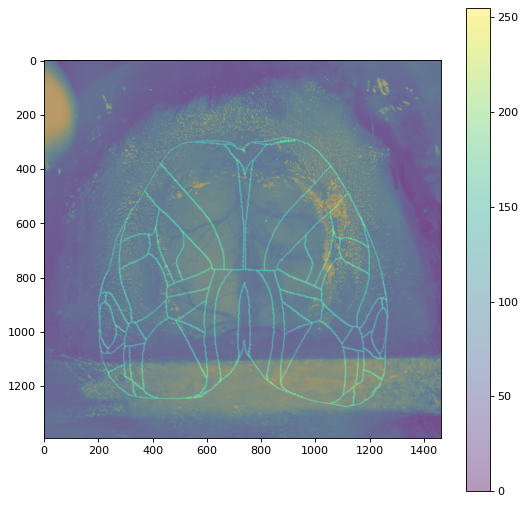

In [103]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(double_transformed_contour.numpy(), alpha=0.6)
plt.imshow(ants_window_image.numpy(), alpha=0.4)
plt.colorbar()
plt.show()

In [42]:
import numpy as np
from skimage.transform import AffineTransform

# Estimate the affine transformation
transform = AffineTransform()
transform.estimate(surgery_labels, window_labels)

# Apply the transformation to a point
transformed_points = transform(surgery_labels)

print(transformed_points)

[[ 690.27537024  957.51722597]
 [ 537.48465014  873.07353156]
 [ 679.74915915  583.27444681]
 [ 956.4016942   711.81509892]
 [ 578.32600398 1008.88783702]
 [ 768.76312229  640.43185972]]


# Tests to save masks